# Verificationm & Validation

In [1]:
import pandas as pd
from envs.citation.models.model_loader import load_model
from helpers.paths import Path
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from visualization.utils import make_defaults
import seaborn as sns
import numpy as np

make_defaults()
citation = load_model("default")

In [2]:
# MATLAB files from csv

states_names = ["p", "q", "r", "V", "alpha", "beta", "phi", "theta", "psi", "he", "xe", "ye"]
input_names = ["de", "da", "dr", "de_t", "da_t", "dr_t", "df", "gear", "throttle_1", "throttle_2"]

df_time = pd.read_csv(Path().data / "citation_time.csv", names=["step"])
df_input = pd.read_csv(Path().data / "citation_input.csv", names=input_names)
df_output = pd.read_csv(Path().data / "citation_states.csv", names=states_names)


In [3]:
citation.initialize()

results = []
# Loop over df_input rows
for i in range(len(df_input)):
    # Get input
    input_values = df_input.iloc[i].values

    # Simulate
    response = citation.step(input_values)

    # Get output
    results.append(response)

results_df = pd.DataFrame(results, columns=states_names)

df_input["step"] = df_time["step"]
df_output["step"] = df_time["step"]
results_df["step"] = df_time["step"]

# Transform angles to degrees
angles = ["p", "q", "r", "alpha", "beta", "phi", "theta", "psi"]
df_output[angles] = np.rad2deg(df_output[angles])
results_df[angles] = np.rad2deg(results_df[angles])
df_input[["de", "da", "dr"]] = np.rad2deg(df_input[["de", "da", "dr"]])

In [4]:

df_sq_error = (results_df - df_output)**2

In [5]:
df_input

,de,da,dr,de_t,da_t,dr_t,df,gear,throttle_1,throttle_2,step
0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.00
1,0.0,0.0,0.0,0,0,0,0,0,0,0,0.01
2,0.0,0.0,0.0,0,0,0,0,0,0,0,0.02
3,0.0,0.0,0.0,0,0,0,0,0,0,0,0.03
4,0.0,0.0,0.0,0,0,0,0,0,0,0,0.04
...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,0.0,0.0,0,0,0,0,0,0,0,4.96
497,0.0,0.0,0.0,0,0,0,0,0,0,0,4.97
498,0.0,0.0,0.0,0,0,0,0,0,0,0,4.98
499,0.0,0.0,0.0,0,0,0,0,0,0,0,4.99


In [6]:
df_sq_error.mean() **.5

p        3.476134e-17
q        1.071723e-02
r        1.692109e-17
V        1.052811e-03
alpha    2.640533e-03
beta     1.590591e-17
phi      8.156427e-17
theta    4.048177e-03
psi      1.573161e-16
he       1.047656e-02
xe       7.029165e-04
ye       4.704724e-16
step     0.000000e+00
dtype: float64

In [7]:
def plot_states(df_states, df_track, with_legend=True, fig_ax=None, matlab=False):
    dpi = 200
    if fig_ax is None:
        fig, axes = plt.subplots(6, 2, sharex=True, figsize=(5, 7), dpi=dpi)
    else:
        fig, axes = fig_ax

    if matlab:
        color = "tab:orange"  # Assign consistent color to state lines
        marker = "o"
    else:
        color = "tab:blue"  # Assign consistent color to state lines
        marker = "d"

    # Plot with consistent color scheme and legend
    def plot_data(data, x, y, ax, ylabel):
        sns.lineplot(data=data, x=x, y=y, ax=ax, color=color)
        # make scatter points on 5 data points
        if matlab:
            marker_values = np.linspace(0, len(data) - 1, 5, dtype=int)
        else:
            marker_values = np.linspace(0, len(data) - 1, 3, dtype=int)
        sns.scatterplot(
            data=data.iloc[marker_values],
            x=x,
            y=y,
            ax=ax,
            color=color,
            marker=marker,
            s=50,
        )
        ax.set_ylabel(ylabel)
        ax.yaxis.set_label_coords(-0.2, 0.5)

    # Call plot_data for each subplot
    plot_data(df_states, "step", "q", axes[0, 0], r"$q$ [deg/s]")
    plot_data(df_states, "step", "p", axes[0, 1], r"$p$ [deg/s]")
    plot_data(df_states, "step", "alpha", axes[1, 0], r"$\alpha$ [deg]")
    plot_data(df_states, "step", "r", axes[1, 1], r"$r$ [deg/s]")
    plot_data(df_states, "step", "theta", axes[2, 0], r"$\theta$ [deg]")
    plot_data(df_states, "step", "phi", axes[2, 1], r"$\phi$ [deg]")
    plot_data(df_states, "step", "V", axes[3, 0], r"$V$ [m/s]")
    plot_data(df_states, "step", "beta", axes[3, 1], r"$\beta$ [deg]")
    plot_data(df_states, "step", "he", axes[4, 0], r"$h$ [m]")
    plot_data(df_track, "step", "da", axes[4, 1], r"$\delta_{a}$ [deg]")
    plot_data(df_track, "step", "de", axes[5, 0], r"$\delta_{e}$ [deg]")
    plot_data(df_track, "step", "dr", axes[5, 1], r"$\delta_{r}$ [deg]")

    axes[5, 0].set_xlabel("Time [s]")
    axes[5, 1].set_xlabel("Time [s]")

    if with_legend:
        state_line = mlines.Line2D([], [], color='tab:orange', label="MATLAB", marker="o")
        # Add marker to line
        ref_line = mlines.Line2D(
            [], [], color="tab:blue", label="Python", marker="d"
        )
        fig.legend(
            handles=[state_line, ref_line], loc="upper center", ncol=2, fontsize=12
        )

    plt.tight_layout(
        pad=0.2, rect=[0, 0, 1, 0.94]
    )  # adjust the rectangle in which to fit the subplots

    return fig, axes


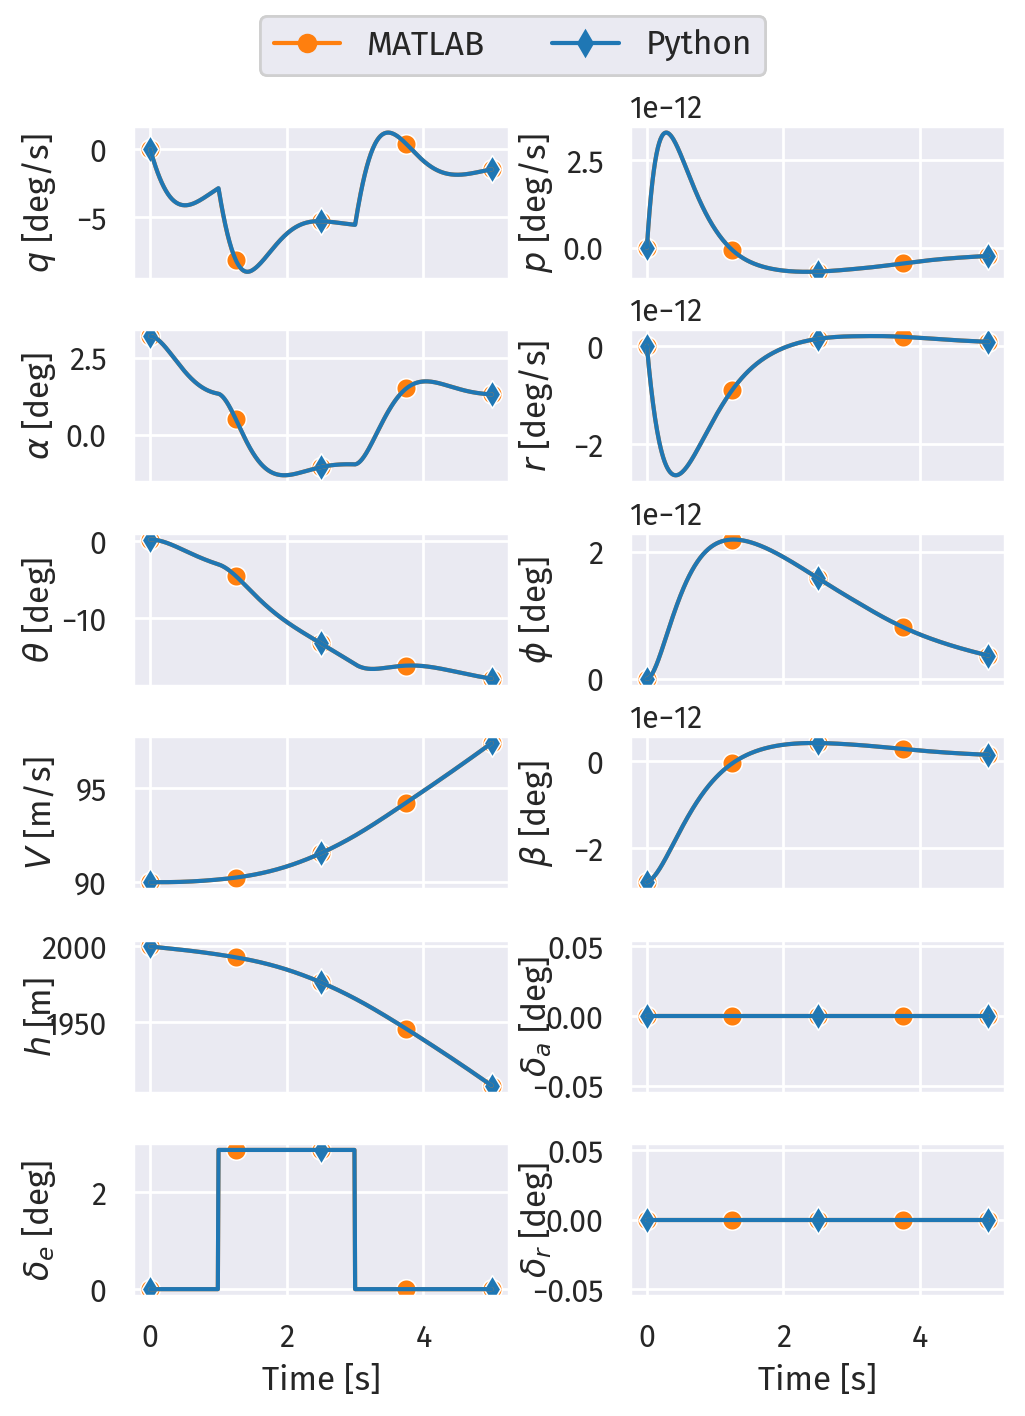

In [8]:
fig, axes = plot_states(df_output, df_input, matlab=True)
plot_states(results_df, df_input, fig_ax=(fig, axes))
if True:
    plt.savefig(f"{Path().paper_figures}/verification_citation.pdf", bbox_inches="tight")

In [9]:
df_result

NameError: name 'df_result' is not defined

In [ ]:
df_output
sns.lineplot(data=df_output, x="step", y="q")